In [1]:
import tensorflow as tf
import os
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

image_dir = "../images"

## 从record文件中读取图片


In [2]:
def read_from_record(record_path, num_epochs = None):
    #根据文件名生成一个队列
    filename_queue = tf.train.string_input_producer([record_path])
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)   #返回文件名和文件
    features = tf.parse_single_example(serialized_example,
                                       features={
                                           'label': tf.FixedLenFeature([], tf.int64),
                                           'img_raw' : tf.FixedLenFeature([], tf.string),
                                       })

    
    img = tf.decode_raw(features['img_raw'], tf.uint8)
    img = tf.reshape(img, [299, 299, 3])
    #img = tf.cast(img, tf.float32) * (1. / 255) - 0.5
    label = tf.cast(features['label'], tf.int32)
    return img,label

## 从文件夹中读取图片

In [3]:
def read_img(filename_queue):
    reader = tf.WholeFileReader()
    label ,img = reader.read(filename_queue)
    img = tf.image.decode_jpeg(img,channels = 3)
    img = tf.image.resize_images(img, [299, 299])
    #img = tf.cast(img, tf.float32) * (1. / 255) - 0.5
    img = tf.cast(img, tf.uint8)
    return img, label

In [4]:
def input_pipeline(file_dir, batch_size, num_epochs=None, IsRecord = False):
        
        if IsRecord:
            img, label = read_from_record(os.path.join(file_dir,"train.tfrecords") ,num_epochs=num_epochs)
        else:
            filenames = [os.path.join(file_dir,filename) for filename in os.listdir(file_dir)]
            filename_queue = tf.train.string_input_producer(
                filenames, num_epochs=num_epochs, shuffle=True)
            img, label = read_img(filename_queue)
            # min_after_dequeue defines how big a buffer we will randomly sample
            #   from -- bigger means better shuffling but slower start up and more
            #   memory used.
            # capacity must be larger than min_after_dequeue and the amount larger
            #   determines the maximum we will prefetch.  Recommendation:
            #   min_after_dequeue + (num_threads + a small safety margin) * batch_size
        min_after_dequeue = 1000
        capacity = min_after_dequeue + 3 * batch_size
        img_batch, label_batch = tf.train.shuffle_batch(
                [img, label], batch_size=batch_size, capacity=capacity,
                min_after_dequeue=min_after_dequeue)
        return img_batch, label_batch


../images
(1, 299, 299, 3)
<class 'numpy.ndarray'>


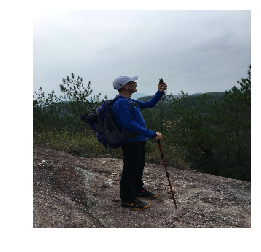

(1, 299, 299, 3)
<class 'numpy.ndarray'>


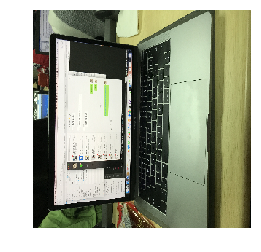

(1, 299, 299, 3)
<class 'numpy.ndarray'>


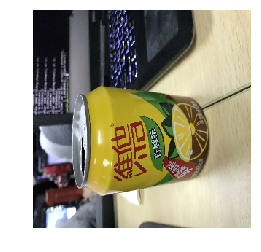

In [9]:
file_dir = "../images"
img_batch, _ = input_pipeline(file_dir, batch_size = 1, num_epochs = 5,IsRecord = False)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    coord=tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    print(file_dir)
    for _ in range(3):
        val= sess.run(img_batch)
        print(val.shape)
        print(type(val))
        plt.figure()
        plt.imshow(val[0])
        plt.axis('off')
        plt.show()
    
    coord.request_stop()
    coord.join(threads)


In [11]:
type(img_batch)

tensorflow.python.framework.ops.Tensor